In [120]:
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import seaborn
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

from skopt.space import Real, Integer
from skopt import BayesSearchCV
import requests
import json
from entsoe import EntsoePandasClient

In [156]:
df = pd.read_csv("../datasets/energy_dataset.csv")
#print(df.columns)
#print(df.head)
columns = ["generation hydro pumped storage aggregated", "forecast wind offshore eday ahead", "generation fossil coal-derived gas", "generation wind offshore", "generation marine", "generation geothermal",
"generation fossil peat","generation fossil oil shale","forecast solar day ahead","forecast wind onshore day ahead","total load forecast","price day ahead","price actual"]
df = df.drop(columns,axis = 1)
#plt.matshow(df.corr())
df.fillna(df.interpolate(method="linear"),inplace=True)
#plt.show()
#df.mean()
#df.var()
df["time"] = pd.to_datetime(df["time"],format = "%Y-%m-%d %H:%M:%S")
df['time'] = df['time'].apply(lambda x: x.replace(tzinfo=None))
df["time"] = pd.to_datetime(df["time"],format="ISO8601")
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
df["week"] = df["time"].dt.weekday
df = df.set_index('time')
print(df["week"].value_counts(0)) 

3    5016
4    5016
5    5016
6    5016
0    5016
1    4992
2    4992
Name: week, dtype: int64


In [157]:

x = df.drop("total load actual",axis = 1)
y = df["total load actual"]
tss = TimeSeriesSplit(n_splits=2)

for train,test in tss.split(df):
    trainx, testx = x.iloc[train,:], x.iloc[test,:]
    trainy, testy = y.iloc[train], y.iloc[test]


print(testx.columns)

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'year', 'month', 'week'],
      dtype='object')


In [116]:
#"https://apidatos.ree.es/en/datos/demanda/demanda-maxima-horaria?start_date=2019-01-01T00:00&end_date=2019-01-31T23:59&time_trunc=month"
response = requests.get("https://apidatos.ree.es/en/datos/generacion/estructura-generacion?start_date=2019-01-01T00:00&end_date=2019-01-31T23:59&time_trunc=month")
print(response.status_code)
ope = response.json()
print(ope)
ope["data"].keys()

200


In [207]:

client = EntsoePandasClient(api_key= "b337a1d6-b64c-49db-ac5a-8a260d29ec52")

"""start = pd.Timestamp('20230101', tz='Europe/Madrid')
end = pd.Timestamp('20230102', tz='Europe/Madrid')"""

start = pd.Timestamp(year=2017, month=1, day=1, hour=0, tz = 'Europe/Madrid' )
end = pd.Timestamp(year=2018, month=1, day=1, hour=0, tz = 'Europe/Madrid' )
process_type = 'A16'

# methods that return Pandas Series
#client.query_day_ahead_prices(country_code, start=start, end=end)
#energy = client.query_generation_import(country_code, start, end)
load  = client.query_load("ES", start = start, end=end)
energy = client.query_generation("ES", start = start, end = end)
#client.query_generation_import("ES",start = start, end = end)
#df3 = client.query_net_position(country_code, start=start, end=end, dayahead=True)
#client.query_crossborder_flows(country_code_from, country_code_to, start=start, end=end)


c:\Python39\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
c:\Python39\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [205]:

#columns = [('Import', 'NL'),('Import', 'DE_AT_LU'),('Import', 'FR')]

#energy = energy.drop(columns,axis =1)
energy.columns
df2 = pd.concat([energy,load],axis=1)
#df2.head

MultiIndex([('Generation',                      'Fossil Gas'),
            ('Generation',                      'Fossil Oil'),
            ('Generation',            'Hydro Pumped Storage'),
            ('Generation', 'Hydro Run-of-river and poundage'),
            ('Generation',                         'Nuclear'),
            ('Generation',                           'Other'),
            ('Generation',                           'Solar'),
            ('Generation',                           'Waste'),
            ('Generation',                   'Wind Offshore'),
            ('Generation',                    'Wind Onshore'),
            (    'Import',                              'NL')],
           )

In [158]:
estimators = [
    ("reg", XGBRegressor())
]


search_params = {
    "reg__max_depth": Integer(2,8),
    "reg__learning_rate": Real(0.001,0.1,prior="log-uniform"),
    "reg__subsample": Real(0.5,1.0),
    "reg__reg_alpha": Real(0.0,10.0),
    "reg__reg_lambda": Real(0.0,10.0),
    "reg__gamma": Real(0.0,10.0)

}
pipe = Pipeline(steps = estimators)
opt = BayesSearchCV(pipe, search_params,cv=2,n_iter = 10, scoring = "r2")


opt.fit(trainx,trainy)


BayesSearchCV(cv=2,
              estimator=Pipeline(steps=[('reg',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=N...
                             'reg__learning_rate': Real(low=0.001, high=0.1, prior='log-uniform', transform='normalize'),
                             'reg__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'reg__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'reg__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'reg__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [159]:
opt.best_score_
opt.cv_results_

{'mean_fit_time': array([0.14433587, 0.44664741, 0.11209631, 0.31694424, 0.19939208,
        0.21898484, 0.19368768, 0.09424043, 0.45309639, 0.51681864]),
 'std_fit_time': array([0.00992   , 0.06373596, 0.00744009, 0.00198448, 0.00843143,
        0.00024819, 0.0022316 , 0.01537609, 0.01165628, 0.01191795]),
 'mean_score_time': array([0.01066422, 0.01190424, 0.00669587, 0.01264846, 0.0089277 ,
        0.01239955, 0.00818491, 0.00818408, 0.01339185, 0.00991988]),
 'std_score_time': array([3.22413445e-03, 4.96149063e-04, 1.24013424e-03, 7.43746758e-04,
        4.95791435e-04, 9.91940498e-04, 7.44581223e-04, 2.23243237e-03,
        3.57627869e-07, 4.96149063e-04]),
 'param_reg__gamma': masked_array(data=[8.899883807970571, 7.940158663136502,
                    7.406711438624438, 4.500565279769743,
                    0.8438957938204795, 7.725937957609267,
                    1.1101948639294614, 0.10832945541527252,
                    7.658391157358297, 7.082680653442701],
              m

In [160]:
opt.score(testx,testy)

0.8864712914872862

<bound method NDFrame.head of                      total load actual  predicted load
time                                                  
2017-09-01 01:00:00            24203.0    23765.910156
2017-09-01 02:00:00            23045.0    22645.078125
2017-09-01 03:00:00            22566.0    21835.062500
2017-09-01 04:00:00            22607.0    21831.791016
2017-09-01 05:00:00            23178.0    22886.533203
...                                ...             ...
2018-12-31 19:00:00            30653.0    32162.656250
2018-12-31 20:00:00            29735.0    31585.291016
2018-12-31 21:00:00            28071.0    29963.052734
2018-12-31 22:00:00            25801.0    27723.449219
2018-12-31 23:00:00            24455.0    27394.041016

[11688 rows x 2 columns]>


<AxesSubplot: xlabel='time'>

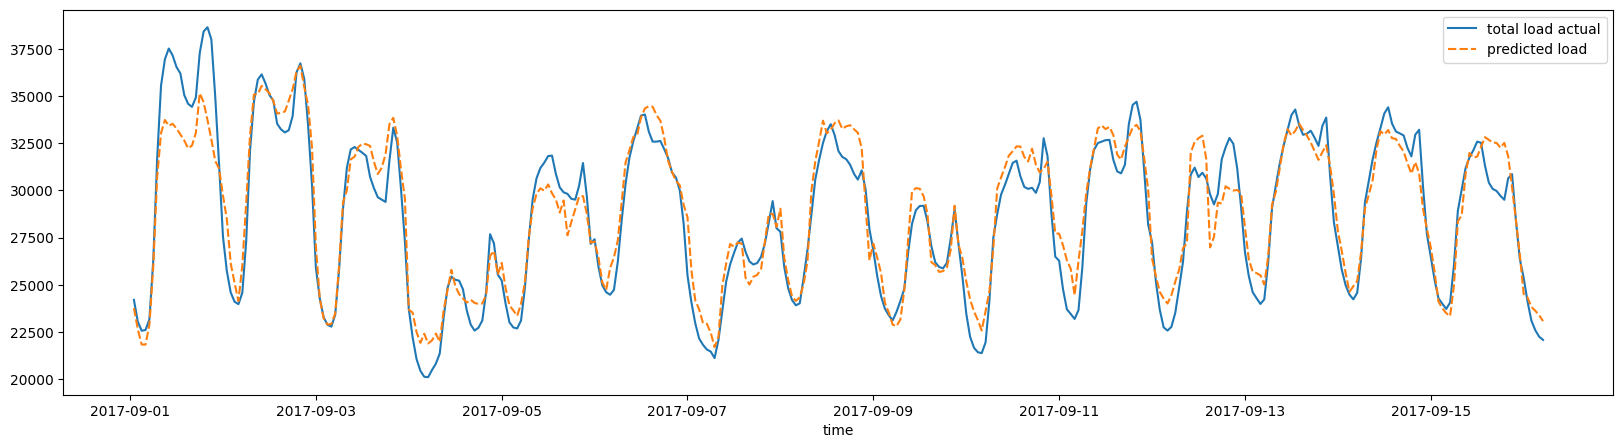

In [150]:
testx.columns
predy = opt.predict(testx)
fig, ax = plt.subplots(figsize=[20,5])


#data = np.vstack((predy[0:7],testy.iloc[0:7].to_numpy()))
predicted = pd.DataFrame(data = predy,index = testx.index,columns=["predicted load"])
#predicted.head
data = pd.concat([testy,predicted],axis=1)
#print(predicted.head)
#print(testy.iloc[0])
print(data.head)
timespan = {"week":7}
#seaborn.lineplot(ax = ax, x = testx.index[0:7],y = data)
seaborn.lineplot(ax = ax, data = data[0:365])
#print(predy[0:7])